In [ ]:
import numpy as np
from tqdm import tqdm
import math
import torch
import random
import os
import copy
import time
import pickle


!pip install tensorboardX
import tensorboardX
from tensorboardX import SummaryWriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
import argparse
def args_parser():


    parser = argparse.ArgumentParser()
    parser.add_argument('-f')

    # federated arguments (Notation for the arguments followed from paper)

    parser.add_argument('--epochs', type=int, default=10,
                        help="number of rounds of training")
    parser.add_argument('--num_users', type=int, default=100,
                        help="number of users: K")
    parser.add_argument('--frac', type=float, default=0.1,
                        help='the fraction of clients: C')
    parser.add_argument('--local_ep', type=int, default=2,
                        help="the number of local epochs: E")
    parser.add_argument('--local_bs', type=int, default=128,
                        help="local batch size: B")
    parser.add_argument('--lr', type=float, default=0.1,
                        help='learning rate')
    parser.add_argument('--momentum', type=float, default=0.99,
                        help='SGD momentum (default: 0.5)')


    # model arguments
    parser.add_argument('--model', type=str, default='resnet', help='model name')
    parser.add_argument('--kernel_num', type=int, default=9,
                        help='number of each kind of kernel')
    parser.add_argument('--kernel_sizes', type=str, default='3,4,5',
                        help='comma-separated kernel size to \
                        use for convolution')
    parser.add_argument('--num_channels', type=int, default=1, help="number \
                        of channels of imgs")
    parser.add_argument('--norm', type=str, default='batch_norm',
                        help="batch_norm, layer_norm, or None")
    parser.add_argument('--num_filters', type=int, default=32,
                        help="number of filters for conv nets -- 32 for \
                        mini-imagenet, 64 for omiglot.")
    parser.add_argument('--max_pool', type=str, default='True',
                        help="Whether use max pooling rather than \
                        strided convolutions")


    # other arguments
    parser.add_argument('--dataset', type=str, default='cifar10', help="name \
                        of dataset")
    parser.add_argument('--num_classes', type=int, default=10, help="number \
                        of classes")
    parser.add_argument('--gpu_id', default=None, help="To use cuda, set \
                        to a specific GPU ID. Default set to use CPU.")
    parser.add_argument('--optimizer', type=str, default='adam', help="type \
                        of optimizer")
    parser.add_argument('--iid', type=int, default=1,
                        help='Default set to IID. Set to 0 for non-IID.')
    parser.add_argument('--unequal', type=int, default=0,
                        help='whether to use unequal data splits for  \
                        non-i.i.d setting (use 0 for equal splits)')
    parser.add_argument('--stopping_rounds', type=int, default=10,
                        help='rounds of early stopping')
    parser.add_argument('--verbose', type=int, default=1, help='verbose')
    parser.add_argument('--seed', type=int, default=1, help='random seed')
    args = parser.parse_args()
    return args

In [ ]:

import numpy as np
from torchvision import datasets, transforms


def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users


def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs -->  200 imgs/shard X 300 shards

    num_shards, num_imgs = 200, 300
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.train_labels.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users


def mnist_noniid_unequal(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset s.t clients
    have unequal amount of data
    :param dataset:
    :param num_users:
    :returns a dict of clients with each clients assigned certain
    number of training imgs
    """
    # 60,000 training imgs --> 50 imgs/shard X 1200 shards
    num_shards, num_imgs = 1200, 50
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.train_labels.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # Minimum and maximum shards assigned per client:
    min_shard = 1
    max_shard = 30

    # Divide the shards into random chunks for every client
    # s.t the sum of these chunks = num_shards
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=num_users)
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)

    # Assign the shards randomly to each client
    if sum(random_shard_size) > num_shards:

        for i in range(num_users):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(num_users):
            if len(idx_shard) == 0:
                continue
            shard_size = random_shard_size[i]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)
    else:

        for i in range(num_users):
            shard_size = random_shard_size[i]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[k] = np.concatenate(
                    (dict_users[k], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

    return dict_users


def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users


def cifar_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    num_shards, num_imgs = 200, 250
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    # labels = dataset.train_labels.numpy()
    labels = np.array(dataset.train_labels)

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users




In [ ]:

import copy
import torch
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST

def get_dataset(args):
    """ Returns train and test datasets and a user group which is a dict where
    the keys are the user index and the values are the corresponding data for
    each of those users.
    """

    if args.dataset == 'cifar10':
        data_dir = './data'
        apply_transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        train_dataset = datasets.CIFAR10(data_dir, train=True, download=True,
                                       transform=apply_transform)

        test_dataset = datasets.CIFAR10(data_dir, train=False, download=True,
                                      transform=apply_transform)

        # sample training data amongst users
        if args.iid:
            # Sample IID user data from Mnist
            user_groups = cifar_iid(train_dataset, args.num_users)
        else:
            # Sample Non-IID user data from Mnist
            if args.unequal:
                # Chose uneuqal splits for every user
                raise NotImplementedError()
            else:
                # Chose euqal splits for every user
                user_groups = cifar_noniid(train_dataset, args.num_users)

    elif args.dataset == 'cifar100':
        data_dir = './data'
        apply_transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
             transforms.RandomHorizontalFlip(),
             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

        train_dataset = datasets.CIFAR100(data_dir, train=True, download=True,
                                       transform=apply_transform)

        test_dataset = datasets.CIFAR100(data_dir, train=False, download=True,
                                      transform=apply_transform)

        # sample training data amongst users
        if args.iid:
            # Sample IID user data from Mnist
            user_groups = cifar_iid(train_dataset, args.num_users)
        else:
            # Sample Non-IID user data from Mnist
            if args.unequal:
                # Chose uneuqal splits for every user
                raise NotImplementedError()
            else:
                # Chose euqal splits for every user
                user_groups = cifar_noniid(train_dataset, args.num_users)


    elif args.dataset == 'mnist':
        data_dir = './data'

        apply_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

        train_dataset = datasets.MNIST(data_dir, train=True, download=True,
                                       transform=apply_transform)

        test_dataset = datasets.MNIST(data_dir, train=False, download=True,
                                      transform=apply_transform)

        # sample training data amongst users
        if args.iid:
            # Sample IID user data from Mnist
            user_groups = mnist_iid(train_dataset, args.num_users)
        else:
            # Sample Non-IID user data from Mnist
            if args.unequal:
                # Chose uneuqal splits for every user
                user_groups = mnist_noniid_unequal(train_dataset, args.num_users)
            else:
                # Chose euqal splits for every user
                user_groups = mnist_noniid(train_dataset, args.num_users)


    elif args.dataset == 'fmnist':
        data_dir = './data'

        apply_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

        train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True,
                                       transform=apply_transform)

        test_dataset = datasets.FashionMNIST(data_dir, train=False, download=True,
                                      transform=apply_transform)

        # sample training data amongst users
        if args.iid:
            # Sample IID user data from Mnist
            user_groups = mnist_iid(train_dataset, args.num_users)
        else:
            # Sample Non-IID user data from Mnist
            if args.unequal:
                # Chose uneuqal splits for every user
                user_groups = mnist_noniid_unequal(train_dataset, args.num_users)
            else:
                # Chose euqal splits for every user
                user_groups = mnist_noniid(train_dataset, args.num_users)

    return train_dataset, test_dataset, user_groups


def average_weights(w):
    """
    Returns the average of the weights.
    """
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg


def exp_details(args):
    print('\nExperimental details:')
    print(f'    Model     : {args.model}')
    print(f'    Dataset   : {args.dataset}')
    print(f'    Optimizer : {args.optimizer}')
    print(f'    Learning  : {args.lr}')
    print(f'    Global Rounds   : {args.epochs}\n')

    print('    Federated parameters:')
    if args.iid:
        print('    IID')
    else:
        print('    Non-IID')
    print(f'    Fraction of users  : {args.frac}')
    print(f'    Local Batch size   : {args.local_bs}')
    print(f'    Local Epochs       : {args.local_ep}\n')
    return

In [ ]:
import torch
import torch.optim as optim

class SAM(torch.optim.Optimizer):
    #define the SAM optimizer class which inherits from torch.optim.Optimizer
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs) #dictionary that holds default values for rho, adaptive, and any aditional keyword arguments
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups #param_groups: attribute of SAM, is set to match the parameter groups of the base-optimizer
        self.defaults.update(self.base_optimizer.defaults) #same as the defaults

    @torch.no_grad()
    # This method modifies the parameters based on the SAM technique. It performs a forward pass with gradient computation but does not update the actual parameters.
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups: #for each parameter group
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]: #For each parameter in the group, its data is being cloned and stored
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    #This method undoes the parameter modifications from first_step and performs the actual optimization step.
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    #This method performs a full optimization step using the SAM technique. It requires a closure, which is a function containing the forward and backward passes.
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True) #The first_step is performed with zeroed gradients.
        closure() #The closure is executed (forward-backward pass).
        self.second_step() #The second_step is executed to perform the actual optimization update.


    # def _grad_norm(self):
    #     shared_device = self.param_groups[0]["params"][0].device
    #     grad_tensors = [
    #       p.grad.norm(p=2).to(shared_device) if p.grad is not None else torch.tensor(1e-12).to(shared_device)
    #       for group in self.param_groups for p in group["params"]
    #     ]
    #     norm = torch.norm(torch.stack(grad_tensors), p=2)
    #     return norm

    def _grad_norm(self):
      shared_device = self.param_groups[0]["params"][0].device
      grad_tensors = [
        p.grad.norm(p=2).to(shared_device)
        for group in self.param_groups for p in group["params"]
        if p.grad is not None
      ]
      if len(grad_tensors) > 0:
        norm = torch.norm(torch.stack(grad_tensors), p=2)
      else:
        norm = torch.tensor(1e-12).to(shared_device)
      return norm


    def load_state_dict(self, state_dict):
        #this method loads the state dictionary of the optimizer.
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [ ]:

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)


class LocalUpdate(object):
    def __init__(self, args, dataset, idxs, logger, p):
        self.args = args
        self.logger = logger
        self.trainloader, self.validloader, self.testloader = self.train_val_test(
            dataset, list(idxs))
        #self.device = 'cuda' if args.gpu else 'cpu'  #########################################CHANGE THIS WHEN ADDING A GPU
        self.device = 'cpu'
        # Default criterion set to NLL loss function
        self.criterion = nn.NLLLoss().to(self.device)

    def train_val_test(self, dataset, idxs):
        """
        Returns train, validation and test dataloaders for a given dataset
        and user indexes.
        """
        # split indexes for train, validation, and test (80, 10, 10)
        idxs_train = idxs[:int(0.8*len(idxs))]
        idxs_val = idxs[int(0.8*len(idxs)):int(0.9*len(idxs))]
        idxs_test = idxs[int(0.9*len(idxs)):]

        trainloader = DataLoader(DatasetSplit(dataset, idxs_train),
                                 batch_size=self.args.local_bs, shuffle=True)
        validloader = DataLoader(DatasetSplit(dataset, idxs_val),
                                 batch_size=int(len(idxs_val)/10), shuffle=False)
        testloader = DataLoader(DatasetSplit(dataset, idxs_test),
                                batch_size=int(len(idxs_test)/10), shuffle=False)
        return trainloader, validloader, testloader

    def update_weights(self, model, global_round,p):
        # Set mode to train model
        model.train()
        epoch_loss = []

        # Set optimizer for the local updates
        # if self.args.optimizer == 'sgd':
        #     optimizer = torch.optim.SGD(model.parameters(), lr=self.args.lr,
        #                                 momentum=0.99)
        # elif self.args.optimizer == 'adam':
        #     optimizer = torch.optim.Adam(model.parameters(), lr=self.args.lr,
        #                                  weight_decay=1e-6)

        optimizer = SAM(model.parameters(), base_optimizer=torch.optim.SGD, rho=0.01, lr=self.args.lr, momentum = 0.5)

        for iter in range(self.args.local_ep):

            #batch_loss = []
            optimizer.zero_grad() #Zero out the gradients
            for batch_idx, (images, labels) in enumerate(self.trainloader):
                images, labels = images.to(self.device), labels.to(self.device)

                #model.zero_grad()
                log_probs = model(images)
                loss = self.criterion(log_probs, labels)
                loss.backward()
                #optimizer.first_step(zero_grad = True)

                ########################################
                def closure():
                    optimizer.zero_grad()
                    log_probs= model(images)
                    loss = self.criterion(log_probs, labels)
                    loss.backward()
                    return loss

                optimizer.step(closure)

                #######################################

                if self.args.verbose and (batch_idx % 10 == 0):
                    print('| Global Round : {} | Local Epoch : {} | [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        global_round, iter, batch_idx * len(images),
                        len(self.trainloader.dataset),
                        100. * batch_idx / len(self.trainloader), loss.item()))

                self.logger.add_scalar('loss', loss.item())
                #batch_loss.append(loss.item())
            #epoch_loss.append(sum(batch_loss)/len(batch_loss))

        #return model.state_dict(), sum(epoch_loss) / len(epoch_loss)
        print("success")
        return model.state_dict()

    def inference(self, model):
        """ Returns the inference accuracy and loss.
        """

        model.eval()
        loss, total, correct = 0.0, 0.0, 0.0

        for batch_idx, (images, labels) in enumerate(self.testloader):
            images, labels = images.to(self.device), labels.to(self.device)

            # Inference
            outputs = model(images)
            batch_loss = self.criterion(outputs, labels)
            loss += batch_loss.item()

            # Prediction
            _, pred_labels = torch.max(outputs, 1)
            pred_labels = pred_labels.view(-1)
            correct += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)

        accuracy = correct/total
        return accuracy, loss


def test_inference(args, model, test_dataset):
    """ Returns the test accuracy and loss.
    """

    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    #device = 'cuda' if args.gpu else 'cpu' ####################################WHEN GPU IS INSTALLED
    device = 'cpu'
    criterion = nn.NLLLoss().to(device)
    testloader = DataLoader(test_dataset, batch_size=128,
                            shuffle=False)

    for batch_idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    accuracy = correct/total
    return accuracy, loss



class calculate(object):
    def __init__(self, args, dataset, idxs, logger):
        self.args = args
        self.logger = logger
        self.trainloader, self.validloader, self.testloader, self.sample_size = self.train_val_test(
            dataset, list(idxs))
        # self.device = 'cuda' if args.gpu else 'cpu'
        self.device = 'cpu'
        # Default criterion set to NLL loss function
        self.criterion = nn.NLLLoss().to(self.device)

    def train_val_test(self, dataset, idxs):
        """
        Returns train, validation and test dataloaders for a given dataset
        and user indexes.
        """
        # split indexes for train, validation, and test (80, 10, 10)
        idxs_train = list(idxs)[:int(0.8*len(idxs))]
        idxs_val = list(idxs)[int(0.8*len(idxs)):int(0.9*len(idxs))]
        idxs_test = list(idxs)[int(0.9*len(idxs)):]

        trainloader = DataLoader(DatasetSplit(dataset, idxs_train),
                                 batch_size=self.args.local_bs, shuffle=True)
        validloader = DataLoader(DatasetSplit(dataset, idxs_val),
                                 batch_size=int(len(idxs_val)/10), shuffle=False)
        testloader = DataLoader(DatasetSplit(dataset, idxs_test),
                                batch_size=int(len(idxs_test)/10), shuffle=False)
        sample_size = len(trainloader.dataset)
        return trainloader, validloader, testloader, sample_size

In [ ]:

from torch import nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, x.shape[1]*x.shape[-2]*x.shape[-1])
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        return self.softmax(x)


class CNNMnist(nn.Module):
    def __init__(self, args):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(args.num_channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, args.num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


class CNNFashion_Mnist(nn.Module):
    def __init__(self, args):
        super(CNNFashion_Mnist, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


class CNNCifar(nn.Module):
    def __init__(self, args):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, args.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

class modelC(nn.Module):
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 96, 3, padding=1)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1)
        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2)
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1)
        self.conv5 = nn.Conv2d(192, 192, 3, padding=1)
        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2)
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1)
        self.conv8 = nn.Conv2d(192, 192, 1)

        self.class_conv = nn.Conv2d(192, n_classes, 1)


    def forward(self, x):
        x_drop = F.dropout(x, .2)
        conv1_out = F.relu(self.conv1(x_drop))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv3_out = F.relu(self.conv3(conv2_out))
        conv3_out_drop = F.dropout(conv3_out, .5)
        conv4_out = F.relu(self.conv4(conv3_out_drop))
        conv5_out = F.relu(self.conv5(conv4_out))
        conv6_out = F.relu(self.conv6(conv5_out))
        conv6_out_drop = F.dropout(conv6_out, .5)
        conv7_out = F.relu(self.conv7(conv6_out_drop))
        conv8_out = F.relu(self.conv8(conv7_out))

        class_out = F.relu(self.class_conv(conv8_out))
        pool_out = F.adaptive_avg_pool2d(class_out, 1)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out




# building a ResNet18 Architecture
#this function creates a 3x3 convolutional layer with specified input and output channels, stride, padding, and without bias
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet18(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:

start_time = time.time()

# define paths
path_project = os.path.abspath('..')
logger = SummaryWriter('../logs')

args = args_parser()
exp_details(args)


device = 'cpu'

# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(args)

# BUILD MODEL
if args.model == 'cnn':
    # Convolutional neural netork
    if args.dataset == 'mnist':
        global_model = CNNMnist(args=args)
    elif args.dataset == 'fmnist':
        global_model = CNNFashion_Mnist(args=args)
    elif args.dataset == 'cifar':
        global_model = CNNCifar(args=args)

elif args.model == 'mlp':
    # Multi-layer preceptron
    img_size = train_dataset[0][0].shape
    len_in = 1
    for x in img_size:
        len_in *= x
        global_model = MLP(dim_in=len_in, dim_hidden=64,
                            dim_out=args.num_classes)
elif args.model == 'resnet':
    global_model = ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10)

else:
    exit('Error: unrecognized model')

# Set the model to train and send it to device.
global_model.to(device)
global_model.train()
print(global_model)

# copy weights
global_weights = global_model.state_dict()

# Training
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 2
val_loss_pre, counter = 0, 0


initial_loss = random.sample(range(args.num_users), args.num_users)
users_pool = np.random.choice(range(args.num_users), args.num_users, replace= False)
users_pool.sort()

weight_coefficients_p = []

for idx in users_pool:
  local_model = calculate(args = args, dataset= train_dataset, idxs = user_groups[idx], logger = logger)
  a, b, d, c = local_model.train_val_test(dataset= train_dataset, idxs=user_groups[idx])
  weight_coefficients_p.append(c)

total_size=sum(weight_coefficients_p)
weight_coefficients_p = [number/ total_size for number in weight_coefficients_p]


# for epoch in tqdm(range(args.epochs)):
for epoch in range(args.epochs):
    args.lr *= 0.99
    print("the new learning rate")
    print(args.lr)
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')

    global_model.train()
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False, p=weight_coefficients_p)

    for idx in idxs_users:
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                  idxs=user_groups[idx], logger=logger, p = weight_coefficients_p[idx])
        # w, loss = local_model.update_weights(
        #     model=copy.deepcopy(global_model), global_round=epoch, p=weight_coefficients_p[idx])
        w = local_model.update_weights(
            model=copy.deepcopy(global_model), global_round=epoch, p=weight_coefficients_p[idx])
        local_weights.append(copy.deepcopy(w))
        #local_losses.append(copy.deepcopy(loss))

    # update global weights
    global_weights = average_weights(local_weights)
    print("these are the global_weights")
    print(global_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    #loss_avg = sum(local_losses) / len(local_losses)
    #train_loss.append(loss_avg)

    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(args.num_users):
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                  idxs=user_groups[idx], logger=logger, p=weight_coefficients_p[idx])
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc)/len(list_acc))

    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
        print(f' \nAvg Training Stats after {epoch+1} global rounds:')
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))

# Test inference after completion of training
test_acc, test_loss = test_inference(args, global_model, test_dataset)

print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))



print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))




Experimental details:
    Model     : resnet
    Dataset   : cifar10
    Optimizer : adam
    Learning  : 0.1
    Global Rounds   : 10

    Federated parameters:
    IID
    Fraction of users  : 0.1
    Local Batch size   : 125
    Local Epochs       : 5



100%|██████████| 170498071/170498071 [00:04<00:00, 40762808.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-0

<ipython-input-6-9d67ed92874a>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


Streaming output truncated to the last 5000 lines.
         ...,

         [[ 0.0427,  0.0197, -0.0075],
          [ 0.1737,  0.0412,  0.0405],
          [ 0.0335, -0.0373,  0.0295]],

         [[ 0.1387,  0.0482, -0.0162],
          [ 0.1227,  0.1485,  0.0564],
          [ 0.0355,  0.1950,  0.0362]],

         [[ 0.0747,  0.0120, -0.0208],
          [-0.0163, -0.0575, -0.0243],
          [ 0.0547,  0.0462, -0.0338]]],


        [[[-0.0800, -0.1218, -0.0665],
          [-0.1990, -0.0739, -0.0405],
          [-0.0108, -0.0671, -0.0946]],

         [[-0.0255, -0.0246, -0.0549],
          [ 0.0431,  0.0627, -0.0049],
          [ 0.0128, -0.0560, -0.0583]],

         [[-0.0095,  0.0187,  0.1128],
          [ 0.1573,  0.0760,  0.0818],
          [-0.0137, -0.0372,  0.1852]],

         ...,

         [[ 0.0752, -0.1022, -0.0224],
          [ 0.1312, -0.0847, -0.0330],
          [ 0.0642, -0.0634, -0.0990]],

         [[-0.0094, -0.0855,  0.0404],
          [-0.0783, -0.0351, -0.0141],
      

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
        -3.3216e+02,  9.3401e+04,  5.0578e+03,  1.6402e+03,  1.2291e+05,
        -6.6001e+01, -1.8960e+04, -1.3021e+03,  1.3770e+03,  1.5433e+03,
        -2.6654e+03, -7.4848e+02, -7.2126e+02, -1.5647e+04,  1.1701e+04,
         1.2233e+04,  1.3169e+04, -2.3038e-01, -1.1009e+00, -1.2927e+00,
        -1.1030e+01, -8.3129e-01,  1.5426e+03,  1.4502e+04, -2.4738e+01,
         6.8684e+03,  1.9650e+04, -4.5383e+01,  3.7219e+03,  8.0264e+00,
        -4.4346e+03,  9.1115e+03,  4.4025e+03, -1.0389e+00,  5.8695e+02,
        -1.4238e+00,  1.7354e+03, -8.5506e+01])), ('layer2.0.downsample.1.running_mean', tensor([ 3.4256e+10,  2.1799e+10, -9.4766e+08, -1.5817e+10, -2.3181e+08,
         2.3428e+09, -2.7606e+10, -1.1393e+08,  5.8253e+05, -2.2103e+11,
         1.0677e+09, -1.1231e+10, -1.4940e+05,  2.6511e+08,  1.4401e+07,
        -3.6595e+07,  3.5967e+08,  4.5280e+08, -1.3412e+10, -3.5419e+08,
         2.7032e+08,  1.2706e+09,  7.2657e+06, -2.1367e+1

In [ ]:
#print(os.getcwd())

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('Agg')
plt.ion()
plt.figure()
plt.plot(range(len(train_accuracy)), train_accuracy)
plt.title('Training accuracy vs communication rounds')
plt.ylabel('Training accuracy')
plt.xlabel('Communication round')
plt.grid(True)
plt.savefig("/content/train_accuracy.png")
plt.show()

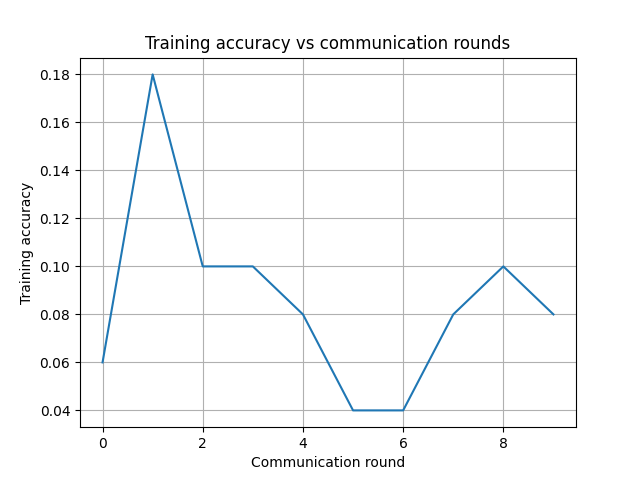

In [ ]:
from IPython.display import Image
Image('/content/train_accuracy.png')